In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

# Spectrum Bounds Analysis

In [2]:
def format_lambda_latex(lamb):
    """Format lambda value as LaTeX 10^{x} notation."""
    import math
    if lamb == 0:
        return r'$0$'
    exp = int(round(math.log10(lamb)))
    return rf'$10^{{{exp}}}$'

In [3]:
def add_theory_band(ax, experiments, min_lambda=None):
    """
    Add theoretical slope band (ε ∝ 1/√(m/d_λ)) to an axis.

    Args:
        ax: Matplotlib axis
        experiments: List of experiment dictionaries with 'm_over_d_lambda' and 'empirical_eps_95'
        min_lambda: Optional minimum lambda threshold to filter experiments
    """
    # Filter experiments if threshold is specified
    filtered_experiments = [e for e in experiments if min_lambda is None or e["lambda"] >= min_lambda]
    all_m_ratio = np.array([e["m_over_d_lambda"] for e in filtered_experiments])
    all_eps = np.array([e["empirical_eps_95"] for e in filtered_experiments])
    mask = np.isfinite(all_m_ratio) & np.isfinite(all_eps) & (all_m_ratio > 0) & (all_eps > 0)
    x_clean, y_clean = all_m_ratio[mask], all_eps[mask]

    if len(x_clean) > 0:
        x_theory = np.logspace(np.log10(x_clean.min()), np.log10(x_clean.max()), 100)
        # Show band of theoretical lines with different constants
        C_med = np.median(y_clean * np.sqrt(x_clean))
        # Extended range with same density (more lines, wider spread)
        # ~6 lines per decade, spanning from 0.001x to 1000x (6 decades = ~36 lines)
        factors = np.logspace(np.log10(0.001), np.log10(1000), 40)
        for factor in factors:
            # Fade alpha towards edges
            dist_from_center = abs(np.log10(factor))
            alpha = 0.18 * np.exp(-0.15 * dist_from_center)  # Slower fade for extended range
            y_theory = (C_med * factor) / np.sqrt(x_theory)
            ax.loglog(x_theory, y_theory, 'k-', alpha=alpha, linewidth=0.8)
        # Add the main reference line
        ax.loglog(x_theory, C_med / np.sqrt(x_theory), 'k--', linewidth=2, alpha=0.7)

        # Store info for annotation (will be added after layout)
        ax._theory_annotation_info = {
            'C_med': C_med,
            'x_theory': x_theory,
        }


def add_theory_annotations(fig, axes):
    """Add annotations with correct slope after figure layout is finalized."""
    # Need to draw first to get accurate transforms
    fig.canvas.draw()

    for ax in axes.flat:
        if not hasattr(ax, '_theory_annotation_info'):
            continue

        info = ax._theory_annotation_info
        C_med = info['C_med']
        x_theory = info['x_theory']

        # Get current axis limits
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        # The line y = C/sqrt(x) exits the visible region at one of two points:
        # 1. Bottom exit: where y = ylim[0], giving x = (C/ylim[0])^2
        # 2. Right exit: where x = xlim[1], giving y = C/sqrt(xlim[1])
        #
        # We place the annotation at whichever exit is within the visible region.

        x_at_bottom = (C_med / ylim[0]) ** 2  # x where line hits y_min
        y_at_right = C_med / np.sqrt(xlim[1])  # y where line hits x_max

        if x_at_bottom <= xlim[1]:
            # Line exits at bottom - place annotation near bottom
            annot_y = ylim[0] * 1.3  # slightly above bottom
            annot_x = (C_med / annot_y) ** 2
        else:
            # Line exits at right - place annotation near right edge
            annot_x = xlim[1] / 2.5  # slightly left of right edge
            annot_y = C_med / np.sqrt(annot_x)

        # Compute angle in display coordinates
        # Take two points on the line and transform to display coords
        x1, x2 = x_theory[50], x_theory[70]
        y1 = C_med / np.sqrt(x1)
        y2 = C_med / np.sqrt(x2)

        # Transform data coordinates to display coordinates
        disp1 = ax.transData.transform((x1, y1))
        disp2 = ax.transData.transform((x2, y2))

        # Compute angle from display coordinates
        dx = disp2[0] - disp1[0]
        dy = disp2[1] - disp1[1]
        angle_deg = np.degrees(np.arctan2(dy, dx))

        # Add annotation close to the line with small offset
        ax.annotate(r'$\epsilon \propto 1/\sqrt{m/d_\lambda}$',
                    xy=(annot_x, annot_y), fontsize=10,
                    ha='center', va='bottom',
                    xytext=(0, 3),  # small offset above the line
                    textcoords='offset points',
                    rotation=angle_deg,
                    rotation_mode='anchor')


def plot_spectrum_comparison(dataset, model, proj_type="sjlt", results_dir="./results/spectrum_bounds",
                             save_path=None, min_lambda=None):
    """
    Compare self-influence and test mode results in a unified 2x2 layout.

    This validates the theoretical bounds from Theorem 1:
    - Self-influence (Eq 1): |φ̃_λ(g) - φ_λ(g)| ≤ ε·φ(g)
      We plot |φ̃_λ/φ_λ - 1| which should be ≤ ε when the bound holds.
    - Bilinear form (Eq 2): |B̃_λ(g,g') - B_λ(g,g')| ≤ ε·√φ_λ(g)·√φ_λ(g')
      We plot the normalized error |B̃-B|/(√φ_g·√φ_v) which should be ≤ ε.

    Layout:
        Top-left: Self-influence error (95th percentile of ratio deviation)
        Top-right: Bilinear form error (95th percentile of normalized error)
        Bottom-left: Eigenvalue spectrum
        Bottom-right: Compression ratio (d_λ / rank)

    Args:
        dataset: Dataset name (e.g., "mnist", "cifar2")
        model: Model name (e.g., "lr", "mlp", "resnet9")
        proj_type: Projection type (default "sjlt")
        results_dir: Directory containing results
        save_path: Optional path to save the figure
        min_lambda: Optional minimum lambda threshold to filter outliers
    """
    # Load both results
    self_path = f"{results_dir}/{dataset}_{model}_{proj_type}_self.pt"
    test_path = f"{results_dir}/{dataset}_{model}_{proj_type}_test.pt"

    if not os.path.exists(self_path):
        print(f"Self-influence results not found: {self_path}")
        return None
    if not os.path.exists(test_path):
        print(f"Test mode results not found: {test_path}")
        return None

    self_results = torch.load(self_path, map_location="cpu", weights_only=False)
    test_results = torch.load(test_path, map_location="cpu", weights_only=False)

    print(f"Loaded results for {dataset}/{model}")
    print(f"  Self mode: {len(self_results['experiments'])} experiments")
    print(f"  Test mode: {len(test_results['experiments'])} experiments")

    # Setup figure: 2 rows x 2 columns
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.suptitle(f'Spectrum Bounds: {dataset.upper()} + {model.upper()}', fontsize=14, fontweight='bold')

    # Get common lambda values
    lambda_values = self_results["lambda_values"]
    if min_lambda is not None:
        lambda_values = [l for l in lambda_values if l >= min_lambda]

    colors = plt.cm.viridis(np.linspace(0, 1, len(lambda_values)))
    legend_fontsize = 8

    # Helper to organize by lambda
    def organize_by_lambda(experiments, lambda_vals):
        by_lambda = {}
        for exp in experiments:
            lamb = exp["lambda"]
            if min_lambda is not None and lamb < min_lambda:
                continue
            if lamb not in by_lambda:
                by_lambda[lamb] = []
            by_lambda[lamb].append(exp)
        return by_lambda

    self_by_lambda = organize_by_lambda(self_results["experiments"], lambda_values)
    test_by_lambda = organize_by_lambda(test_results["experiments"], lambda_values)

    # =========================================================================
    # Plot 1 (Top-Left): Self-influence 95th percentile error
    # Validates Theorem 1 Eq (1): |φ̃_λ - φ_λ| ≤ ε·φ_λ
    # We plot |φ̃_λ/φ_λ - 1| which equals |φ̃_λ - φ_λ|/φ_λ
    # =========================================================================
    ax1 = axes[0, 0]
    ax1.axvline(x=1.0, color='red', linestyle='--', linewidth=2, alpha=0.8, label='$m = d_\\lambda$')

    all_y_self = []
    for i, lamb in enumerate(lambda_values):
        if lamb not in self_by_lambda:
            continue
        exps = sorted(self_by_lambda[lamb], key=lambda x: x["m_over_d_lambda"])
        x = [e["m_over_d_lambda"] for e in exps]
        y = [e["empirical_eps_95"] for e in exps]
        all_y_self.extend(y)
        ax1.loglog(x, y, 'o-', color=colors[i], label=format_lambda_latex(lamb), markersize=6, alpha=0.8)

    # Add theoretical bound line
    add_theory_band(ax1, self_results["experiments"], min_lambda)

    # Set y-limits based on empirical data
    if all_y_self:
        ax1.set_ylim(min(all_y_self) * 0.5, max(all_y_self) * 2.0)

    ax1.set_xlabel('$m / d_\\lambda$')
    ax1.set_ylabel('$|\\tilde{\\phi}_\\lambda/\\phi_\\lambda - 1|$ (95th %ile)')
    ax1.set_ylabel(r"$|\tilde{\phi}_\lambda (g) - \phi_\lambda (g)|/\phi(g)$ (95th %ile)")
    ax1.set_title('Self-Influence Error (Theorem 1, Eq. 1)')
    ax1.legend(fontsize=legend_fontsize)

    # =========================================================================
    # Plot 2 (Top-Right): Test mode (bilinear form) 95th percentile error
    # Validates Theorem 1 Eq (2): |B̃_λ(g,g') - B_λ(g,g')| ≤ ε·√φ_λ(g)·√φ_λ(g')
    # We plot the normalized error: |B̃ - B| / (√φ_g · √φ_v)
    # =========================================================================
    ax2 = axes[0, 1]
    ax2.axvline(x=1.0, color='red', linestyle='--', linewidth=2, alpha=0.8, label='$m = d_\\lambda$')

    all_y_test = []
    for i, lamb in enumerate(lambda_values):
        if lamb not in test_by_lambda:
            continue
        exps = sorted(test_by_lambda[lamb], key=lambda x: x["m_over_d_lambda"])
        x = [e["m_over_d_lambda"] for e in exps]
        y = [e["empirical_eps_95"] for e in exps]
        all_y_test.extend(y)
        ax2.loglog(x, y, 'o-', color=colors[i], label=format_lambda_latex(lamb), markersize=6, alpha=0.8)

    # Add theoretical bound line
    add_theory_band(ax2, test_results["experiments"], min_lambda)

    # Set y-limits based on empirical data
    if all_y_test:
        ax2.set_ylim(min(all_y_test) * 0.5, max(all_y_test) * 2.0)

    ax2.set_xlabel('$m / d_\\lambda$')
    ax2.set_ylabel(r"$|\tilde{B}_\lambda (g, g') - B_\lambda (g, g')|/(\sqrt{\phi_\lambda(g)}\sqrt{\phi_\lambda(g')})$ (95th %ile)")
    ax2.set_title('Bilinear Form Error (Theorem 1, Eq. 2)')
    ax2.legend(fontsize=legend_fontsize)

    # =========================================================================
    # Plot 3 (Bottom-Left): Eigenvalue Spectrum
    # =========================================================================
    ax3 = axes[1, 0]
    eigenvalues = self_results.get("eigenvalues")
    rank = self_results.get("rank", len(eigenvalues) if eigenvalues is not None else 0)

    if eigenvalues is not None:
        ax3.semilogy(eigenvalues[:rank], 'b-', linewidth=1.5)
        ax3.set_xlabel('Index $i$')
        ax3.set_ylabel('Eigenvalue $\\mu_i$')
        ax3.set_title(f'Eigenvalue Spectrum (rank={rank})')
        ax3.grid(True, alpha=0.3)

        if rank > 10:
            log_idx = np.log(np.arange(1, min(rank, 100) + 1))
            log_eig = np.log(eigenvalues[:min(rank, 100)] + 1e-15)
            slope, _ = np.polyfit(log_idx, log_eig, 1)
            ax3.annotate(f'Decay ≈ $i^{{{slope:.2f}}}$', xy=(0.6, 0.9),
                        xycoords='axes fraction', fontsize=10)
    else:
        ax3.text(0.5, 0.5, 'Eigenvalues not available',
                ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Eigenvalue Spectrum')

    # =========================================================================
    # Plot 4 (Bottom-Right): Compression Ratio (d_λ / rank)
    # =========================================================================
    ax4 = axes[1, 1]
    eff_dims = self_results.get("effective_dims", {})
    if eff_dims and rank > 0:
        l_vals = [l for l in lambda_values if l in eff_dims]
        d_vals = [eff_dims[l] for l in l_vals]
        ratios = [d / rank for d in d_vals]

        ax4.semilogx(l_vals, ratios, 'co-', markersize=10, linewidth=2)

        # Annotate each point with the actual d_λ value
        for l, r, d in zip(l_vals, ratios, d_vals):
            ax4.annotate(f'$d_\\lambda$={d:.0f}', (l, r), textcoords="offset points",
                        xytext=(0, 10), ha='center', fontsize=8)

        ax4.axhline(y=1.0, color='r', linestyle='--', alpha=0.7, label='No compression')
        ax4.set_ylim([-0.1, 1.1])
        ax4.legend(fontsize=legend_fontsize)

    ax4.set_xlabel('Regularization $\\lambda$')
    ax4.set_ylabel('$d_\\lambda$ / rank$(F)$')
    ax4.set_title('Compression Ratio')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Add annotations with correct slope after layout
    add_theory_annotations(fig, axes)

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved figure to {save_path}")

    plt.show()
    return fig

# Hyperparameter Selection Comparison

In [4]:
dataset = "cifar2"
model = "resnet9"
proj_type = "sjlt"

hyperparam_results_path = f"./results/hyperparam_selection/{dataset}_{model}_{proj_type}.pt"

if not os.path.exists(hyperparam_results_path):
    print(f"Error: File not found at {hyperparam_results_path}")
    hyperparam_results = None
else:
    hyperparam_results = torch.load(hyperparam_results_path, map_location="cpu", weights_only=False)
    print(f"Loaded hyperparameter comparison results")
    print(f"Dataset: {hyperparam_results.get('dataset', '?')}, Model: {hyperparam_results.get('model', '?')}")

Loaded hyperparameter comparison results
Dataset: cifar2, Model: resnet9


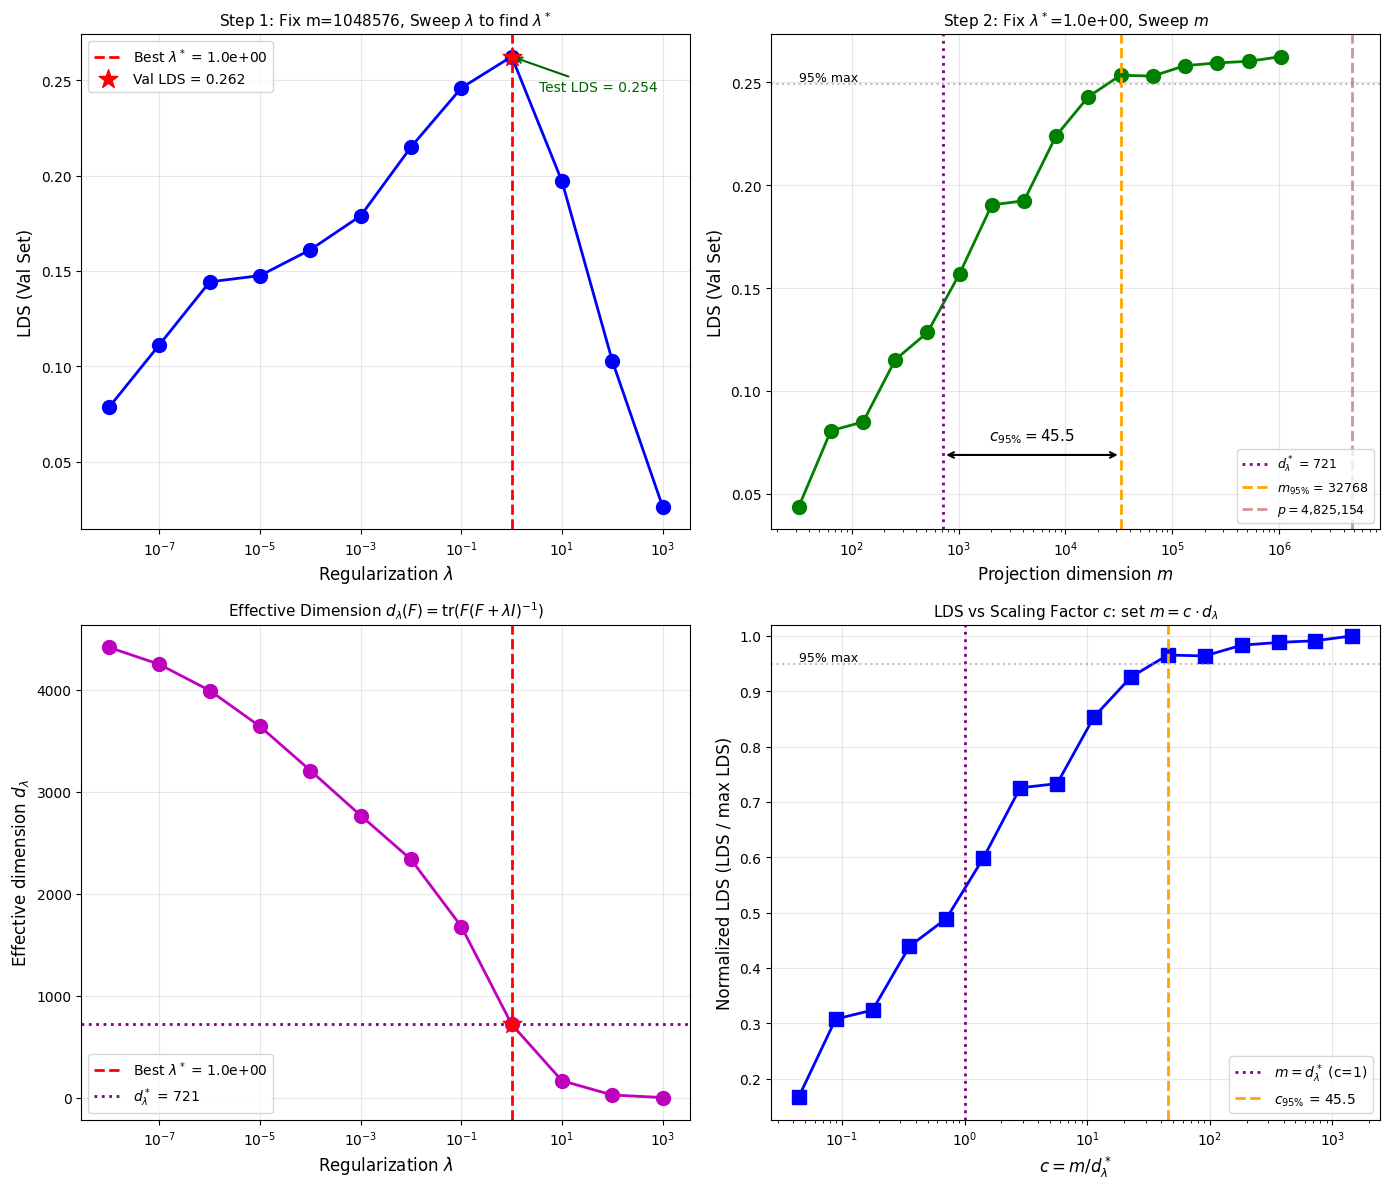


Empirical constant for 95% LDS: c = 45.5
Practical rule: set m = 45 * d_lambda


In [5]:
def plot_comparison_results(results: dict, save_path=None):
    """
    Plot comparison of hyperparameter selection approaches.

    Key insight to demonstrate:
    - Sequential approach: Fix m large -> find lambda* -> study how LDS varies with m
    - Empirically determine constant c such that m = c * d_lambda achieves 95% of max LDS
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    best_lambda = results["lambda_sweep"]["best_lambda"]
    d_lambda_star = results["d_lambda"].get(
        best_lambda,
        results["d_lambda"][min(results["d_lambda"].keys(), key=lambda x: abs(x - best_lambda))]
    )
    n_params = results.get("n_params", None)

    # =========================================================================
    # Plot 1: Step 1 of Sequential Approach - Fix m, sweep lambda
    # =========================================================================
    ax1 = axes[0, 0]
    lambda_vals = results["lambda_sweep"]["lambda_values"]
    val_lds = results["lambda_sweep"]["val_lds"]
    test_lds = results["lambda_sweep"].get("test_lds", None)

    ax1.semilogx(lambda_vals, val_lds, 'bo-', markersize=10, linewidth=2)
    ax1.axvline(x=best_lambda, color='r', linestyle='--', linewidth=2,
                label=f'Best $\\lambda^*$ = {best_lambda:.1e}')

    # Mark the best point
    best_idx = lambda_vals.index(best_lambda) if best_lambda in lambda_vals else \
               val_lds.index(max(val_lds))
    ax1.scatter([lambda_vals[best_idx]], [val_lds[best_idx]], s=200, c='red',
                marker='*', zorder=5, label=f'Val LDS = {val_lds[best_idx]:.3f}')

    # Annotate test LDS at the best lambda point
    if test_lds is not None:
        ax1.annotate(f'Test LDS = {test_lds:.3f}',
                     xy=(lambda_vals[best_idx], val_lds[best_idx]),
                     xytext=(20, -25), textcoords='offset points',
                     fontsize=10, color='darkgreen',
                     arrowprops=dict(arrowstyle='->', color='darkgreen', lw=1.5))

    ax1.set_xlabel('Regularization $\\lambda$', fontsize=12)
    ax1.set_ylabel('LDS (Val Set)', fontsize=12)
    ax1.set_title(f'Step 1: Fix m={results["lambda_sweep"]["proj_dim"]}, Sweep $\\lambda$ to find $\\lambda^*$',
                  fontsize=11)
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)

    # =========================================================================
    # Plot 2: Step 2 of Sequential Approach - Fix lambda*, sweep m
    # =========================================================================
    ax2 = axes[0, 1]
    m_vals = results["m_sweep"]["m_values"]
    m_lds = results["m_sweep"]["val_lds"]

    ax2.semilogx(m_vals, m_lds, 'go-', markersize=10, linewidth=2)

    # Find empirical threshold: where LDS reaches 95% of max
    max_lds = max(m_lds)
    threshold_95 = 0.95 * max_lds
    empirical_min_m = None
    for m, lds_val in zip(m_vals, m_lds):
        if lds_val >= threshold_95:
            empirical_min_m = m
            break

    # Compute the empirical constant c = m_95% / d_lambda*
    c_empirical = empirical_min_m / d_lambda_star if empirical_min_m and d_lambda_star > 0 else None

    # Mark d_lambda* in purple
    ax2.axvline(x=d_lambda_star, color='purple', linestyle=':', linewidth=2,
                label=f'$d_\\lambda^*$ = {d_lambda_star:.0f}')

    # Mark m_95% in orange
    if empirical_min_m:
        ax2.axvline(x=empirical_min_m, color='orange', linestyle='--', linewidth=2,
                    label=f'$m_{{95\\%}}$ = {empirical_min_m}')

    # Mark parameter count on the m-axis
    if n_params is not None:
        ax2.axvline(x=n_params, color='brown', linestyle='--', linewidth=2, alpha=0.5,
                    label=f'$p=${n_params:,}')

    ax2.axhline(y=threshold_95, color='gray', linestyle=':', alpha=0.5)
    ax2.text(min(m_vals), threshold_95, '95% max', fontsize=9, va='bottom')

    # Add c annotation between the two vertical lines
    if c_empirical is not None:
        # Position the annotation between d_lambda* and m_95%
        mid_x = np.sqrt(d_lambda_star * empirical_min_m)  # geometric mean for log scale
        y_pos = ax2.get_ylim()[0] + 0.15 * (ax2.get_ylim()[1] - ax2.get_ylim()[0])
        ax2.annotate('', xy=(empirical_min_m, y_pos), xytext=(d_lambda_star, y_pos),
                     arrowprops=dict(arrowstyle='<->', color='black', lw=1.5))
        ax2.text(mid_x, y_pos+0.005, f'$c_{{95\\%}}={c_empirical:.1f}$',
                 ha='center', va='bottom', fontsize=11, fontweight='bold')

    ax2.set_xlabel('Projection dimension $m$', fontsize=12)
    ax2.set_ylabel('LDS (Val Set)', fontsize=12)
    ax2.set_title(f'Step 2: Fix $\\lambda^*$={best_lambda:.1e}, Sweep $m$',
                  fontsize=11)
    ax2.legend(loc='lower right', fontsize=9)
    ax2.grid(True, alpha=0.3)

    # =========================================================================
    # Plot 3: Effective Dimension vs lambda
    # =========================================================================
    ax3 = axes[1, 0]
    d_lambda_dict = results["d_lambda"]
    lambdas = sorted(d_lambda_dict.keys())
    d_lambdas = [d_lambda_dict[l] for l in lambdas]

    ax3.semilogx(lambdas, d_lambdas, 'mo-', markersize=10, linewidth=2)
    ax3.axvline(x=best_lambda, color='r', linestyle='--', linewidth=2,
                label=f'Best $\\lambda^*$ = {best_lambda:.1e}')
    ax3.axhline(y=d_lambda_star, color='purple', linestyle=':', linewidth=2,
                label=f'$d_\\lambda^*$ = {d_lambda_star:.0f}')

    # Annotate the key point
    ax3.scatter([best_lambda], [d_lambda_star], s=200, c='red', marker='*', zorder=5)

    ax3.set_xlabel('Regularization $\\lambda$', fontsize=12)
    ax3.set_ylabel('Effective dimension $d_\\lambda$', fontsize=12)
    ax3.set_title('Effective Dimension $d_\\lambda(F) = \\mathrm{tr}(F(F+\\lambda I)^{-1})$', fontsize=11)
    ax3.legend(loc='best')
    ax3.grid(True, alpha=0.3)

    # =========================================================================
    # Plot 4: LDS vs m/d_lambda* (scaling behavior) - shows c directly on x-axis
    # =========================================================================
    ax4 = axes[1, 1]

    # Normalize LDS to show relative performance
    normalized_lds = [(lds / max_lds) for lds in m_lds]
    m_over_d = [m / d_lambda_star for m in m_vals]

    ax4.semilogx(m_over_d, normalized_lds, 'bs-', markersize=10, linewidth=2)
    ax4.axvline(x=1.0, color='purple', linestyle=':', linewidth=2,
                label='$m = d_\\lambda^*$ (c=1)')
    ax4.axhline(y=0.95, color='gray', linestyle=':', alpha=0.5)
    ax4.text(min(m_over_d), 0.95, '95% max', fontsize=9, va='bottom')

    # Mark the empirical c value with a vertical line
    if c_empirical is not None:
        ax4.axvline(x=c_empirical, color='orange', linestyle='--', linewidth=2,
                    label=f'$c_{{95\\%}}$ = {c_empirical:.1f}')

    ax4.set_xlabel('$c = m / d_\\lambda^*$', fontsize=12)
    ax4.set_ylabel('Normalized LDS (LDS / max LDS)', fontsize=12)
    ax4.set_title('LDS vs Scaling Factor $c$: set $m = c \\cdot d_\\lambda$', fontsize=11)
    ax4.legend(loc='lower right')
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim([None, 1.02])

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved figure to {save_path}")

    plt.show()

    # Return the empirical constant for use in reports
    return {"c_95": c_empirical, "m_95": empirical_min_m, "d_lambda_star": d_lambda_star}


# Run the function
if hyperparam_results is not None:
    empirical_constants = plot_comparison_results(hyperparam_results)
    if empirical_constants["c_95"]:
        print(f"\nEmpirical constant for 95% LDS: c = {empirical_constants['c_95']:.1f}")
        print(f"Practical rule: set m = {empirical_constants['c_95']:.0f} * d_lambda")

Generating Spectrum Bounds Figures (Combined Self + Test)

>>> MNIST + LR
Loaded results for mnist/lr
  Self mode: 105 experiments
  Test mode: 105 experiments


Saved figure to ./figures/spectrum_bounds/spectrum_mnist_lr.png


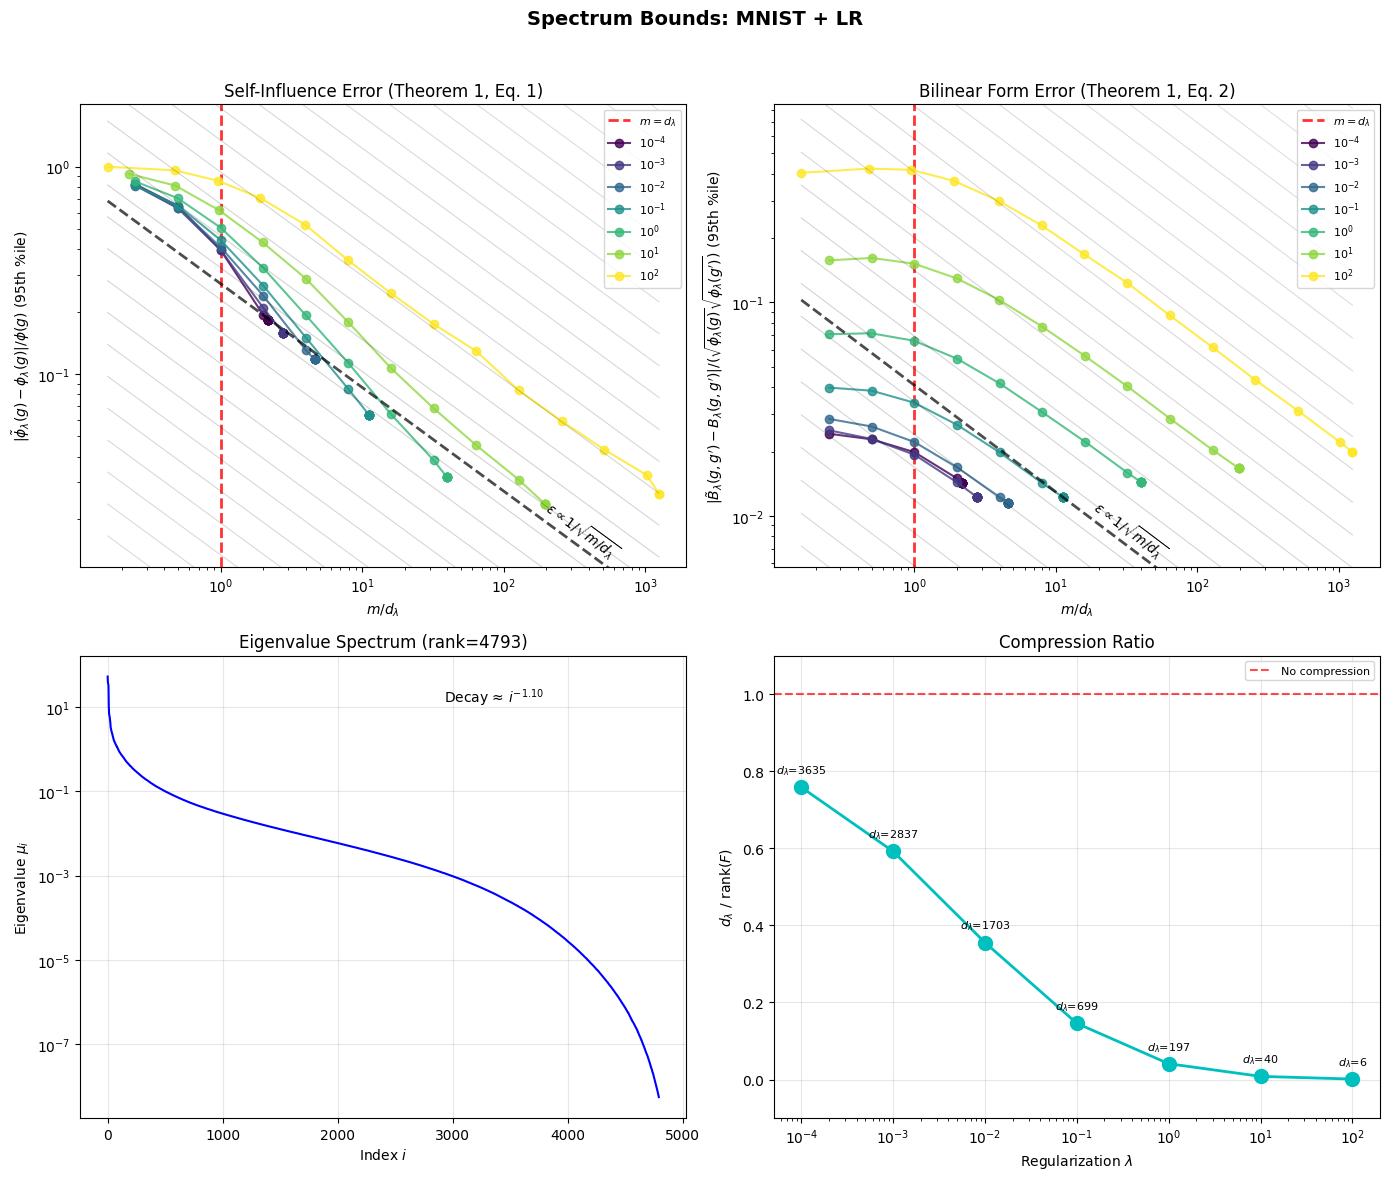


>>> MNIST + MLP
Loaded results for mnist/mlp
  Self mode: 120 experiments
  Test mode: 120 experiments
Saved figure to ./figures/spectrum_bounds/spectrum_mnist_mlp.png


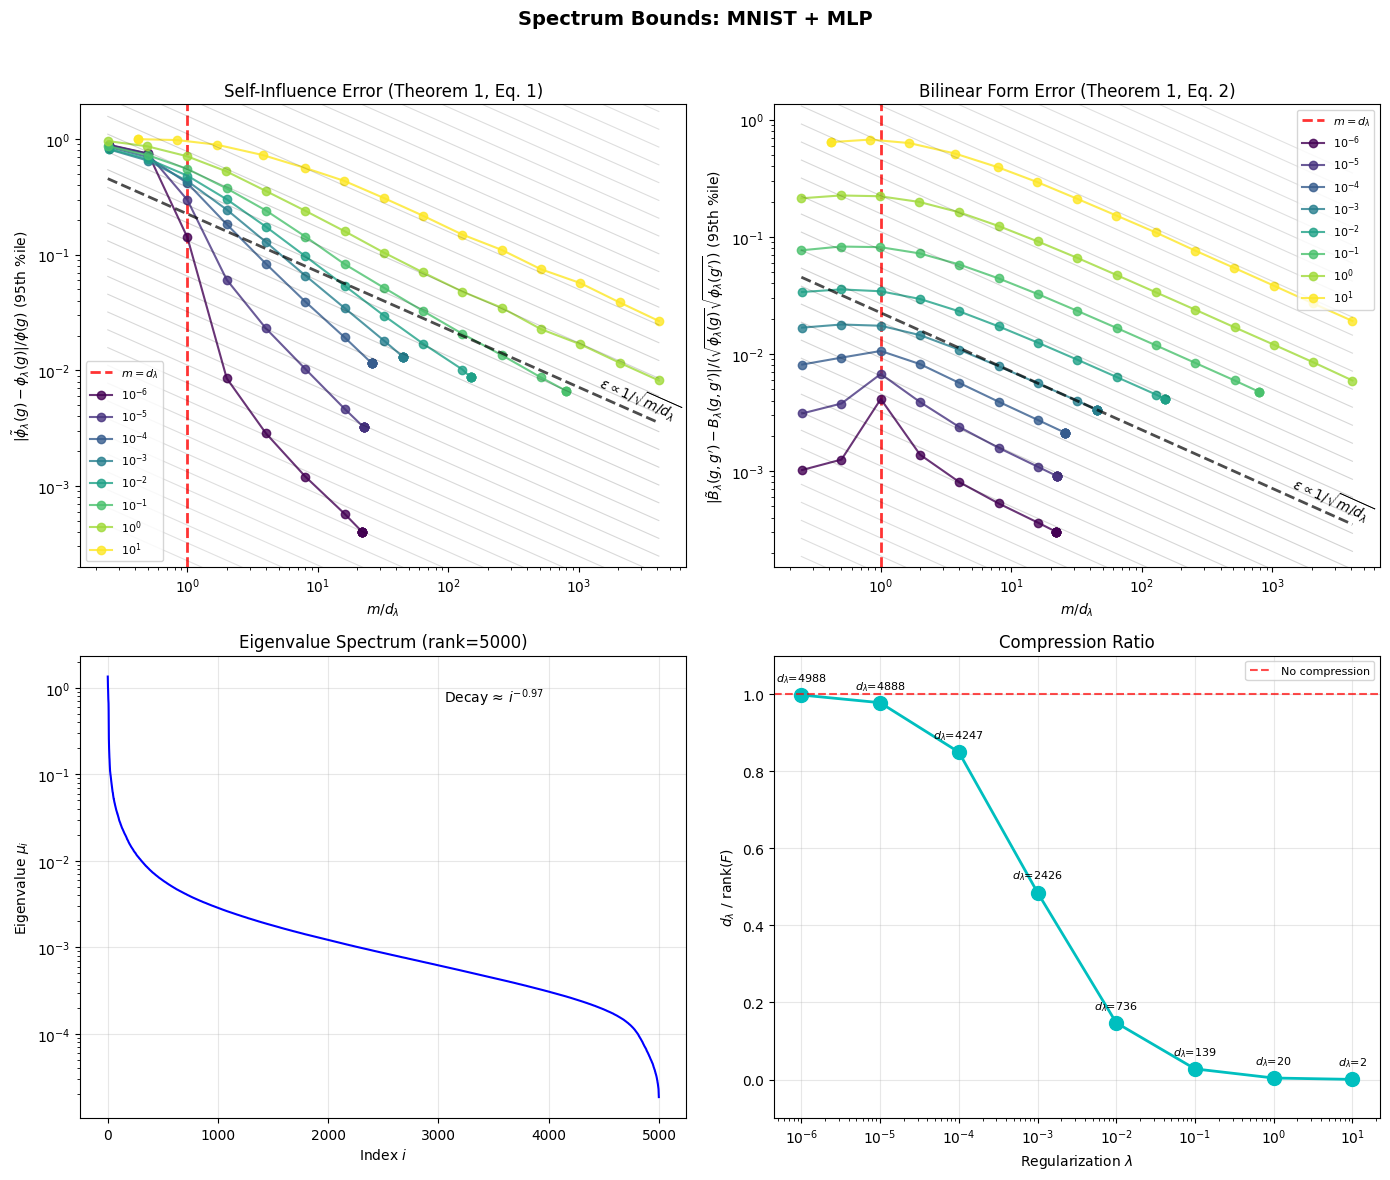


>>> CIFAR2 + RESNET9
Self-influence results not found: ./results/spectrum_bounds/cifar2_resnet9_sjlt_self.pt

Generating Hyperparameter Selection Figures

>>> MNIST + LR
Saved figure to ./figures/hyperparam_selection/hyperparam_mnist_lr.png


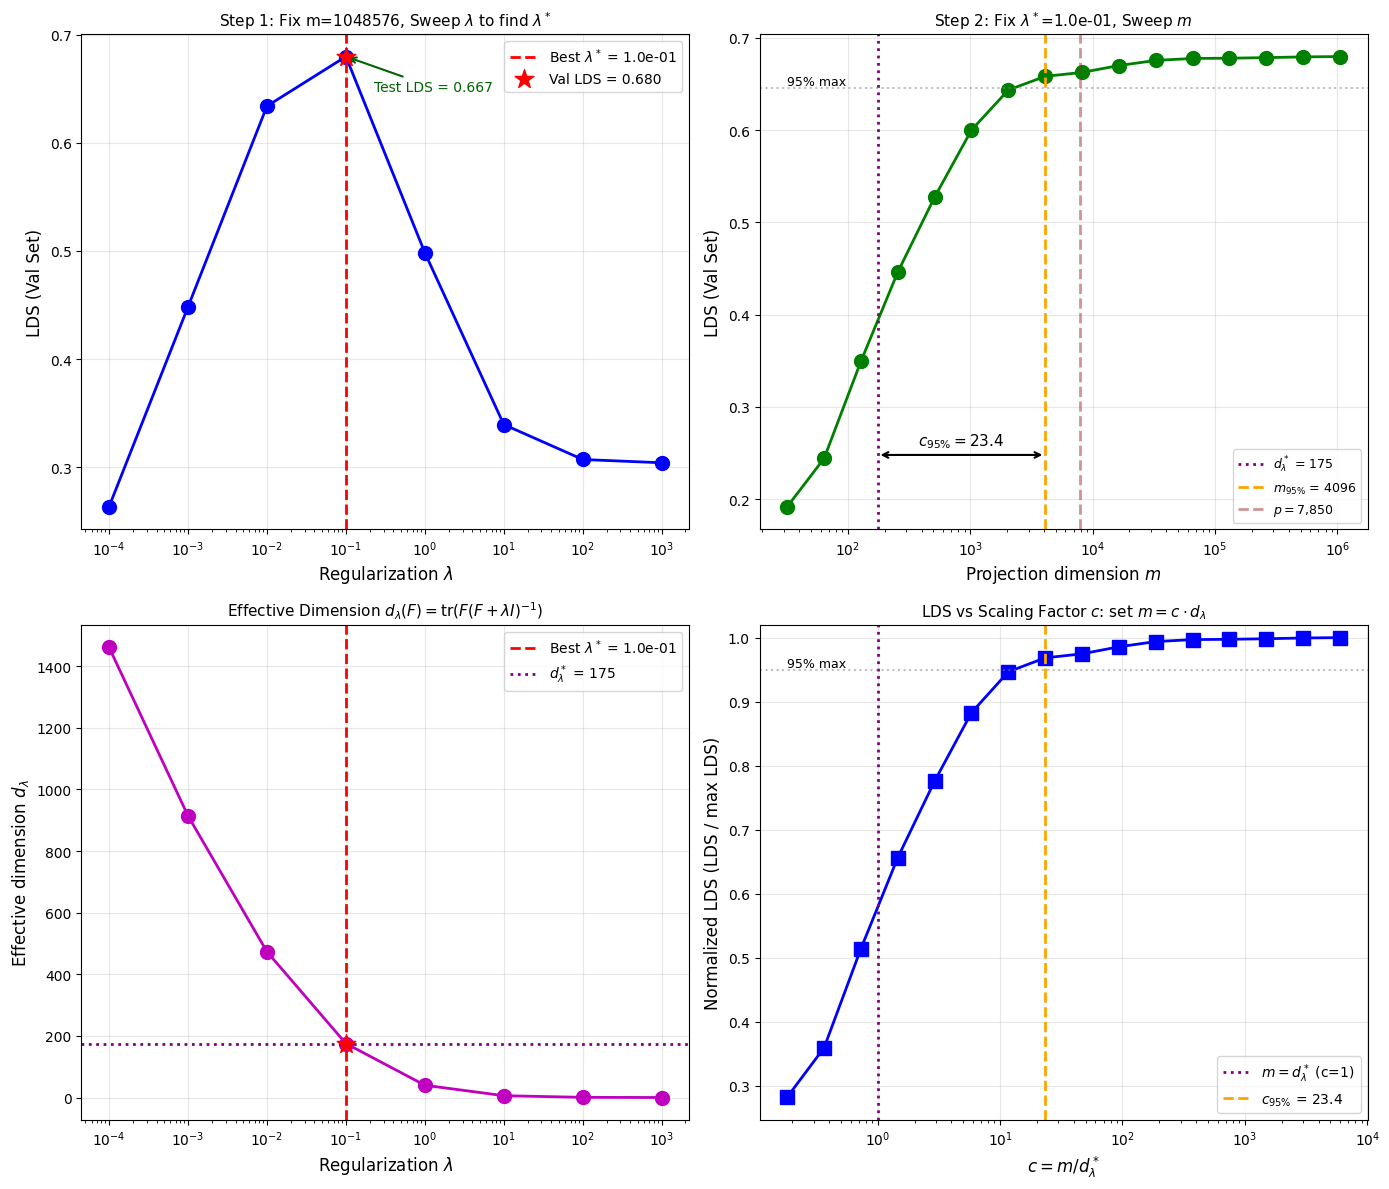


>>> MNIST + MLP
Saved figure to ./figures/hyperparam_selection/hyperparam_mnist_mlp.png


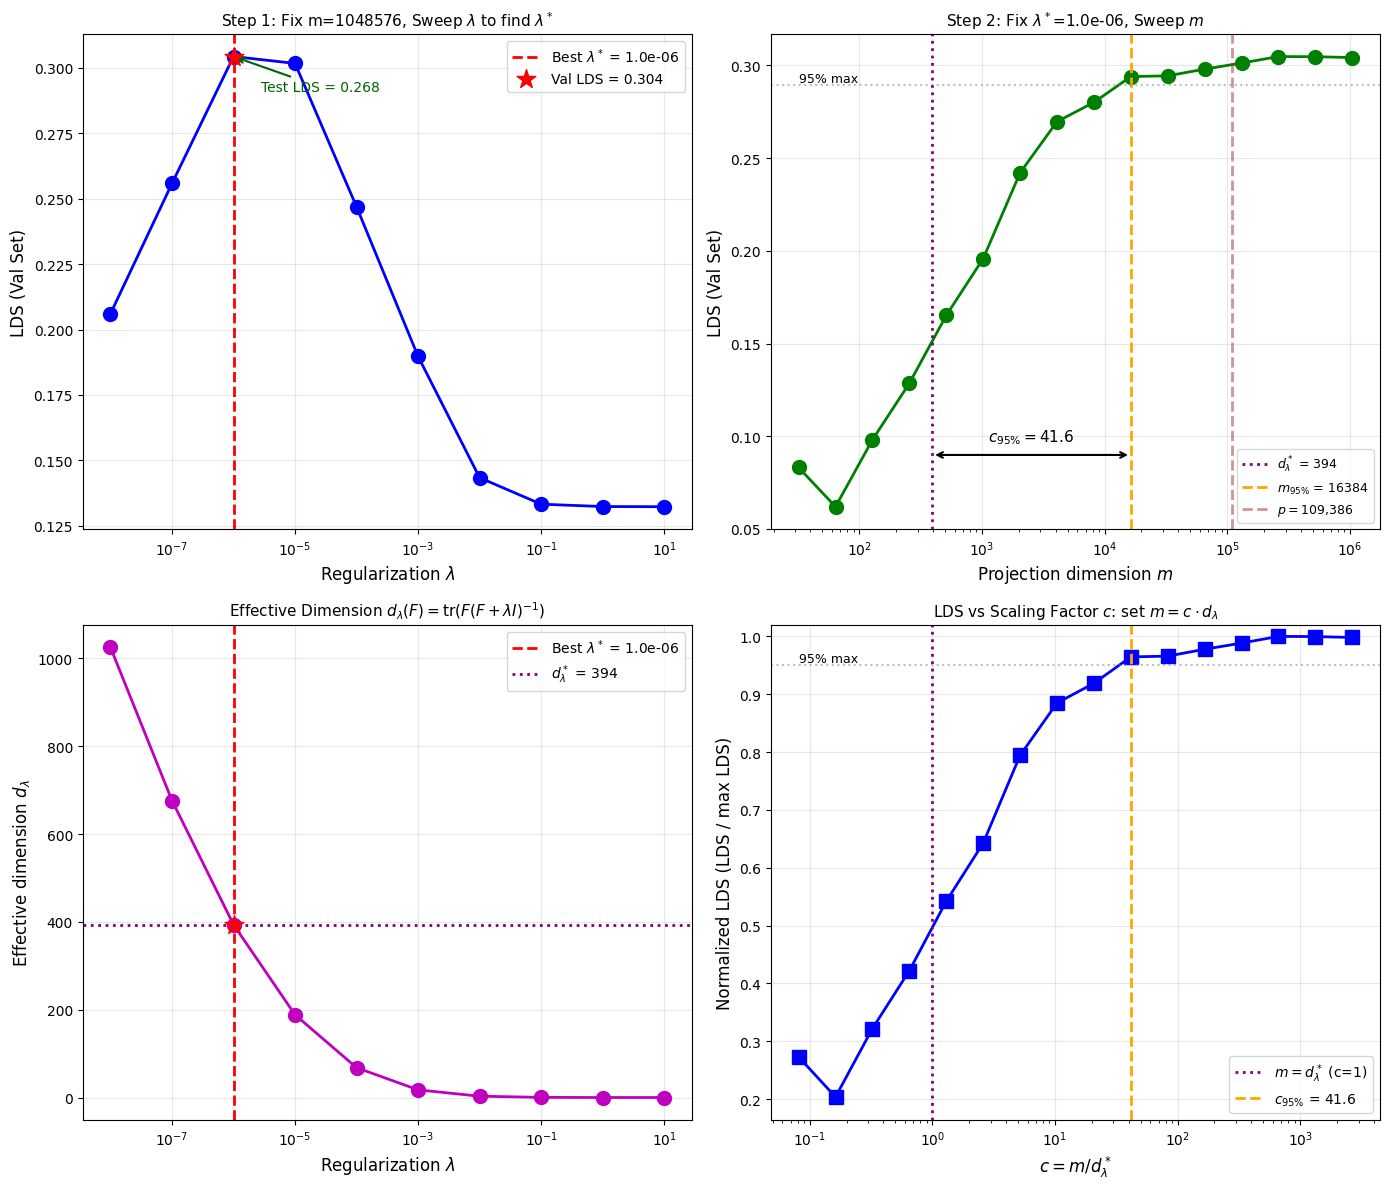


>>> CIFAR2 + RESNET9
Saved figure to ./figures/hyperparam_selection/hyperparam_cifar2_resnet9.png


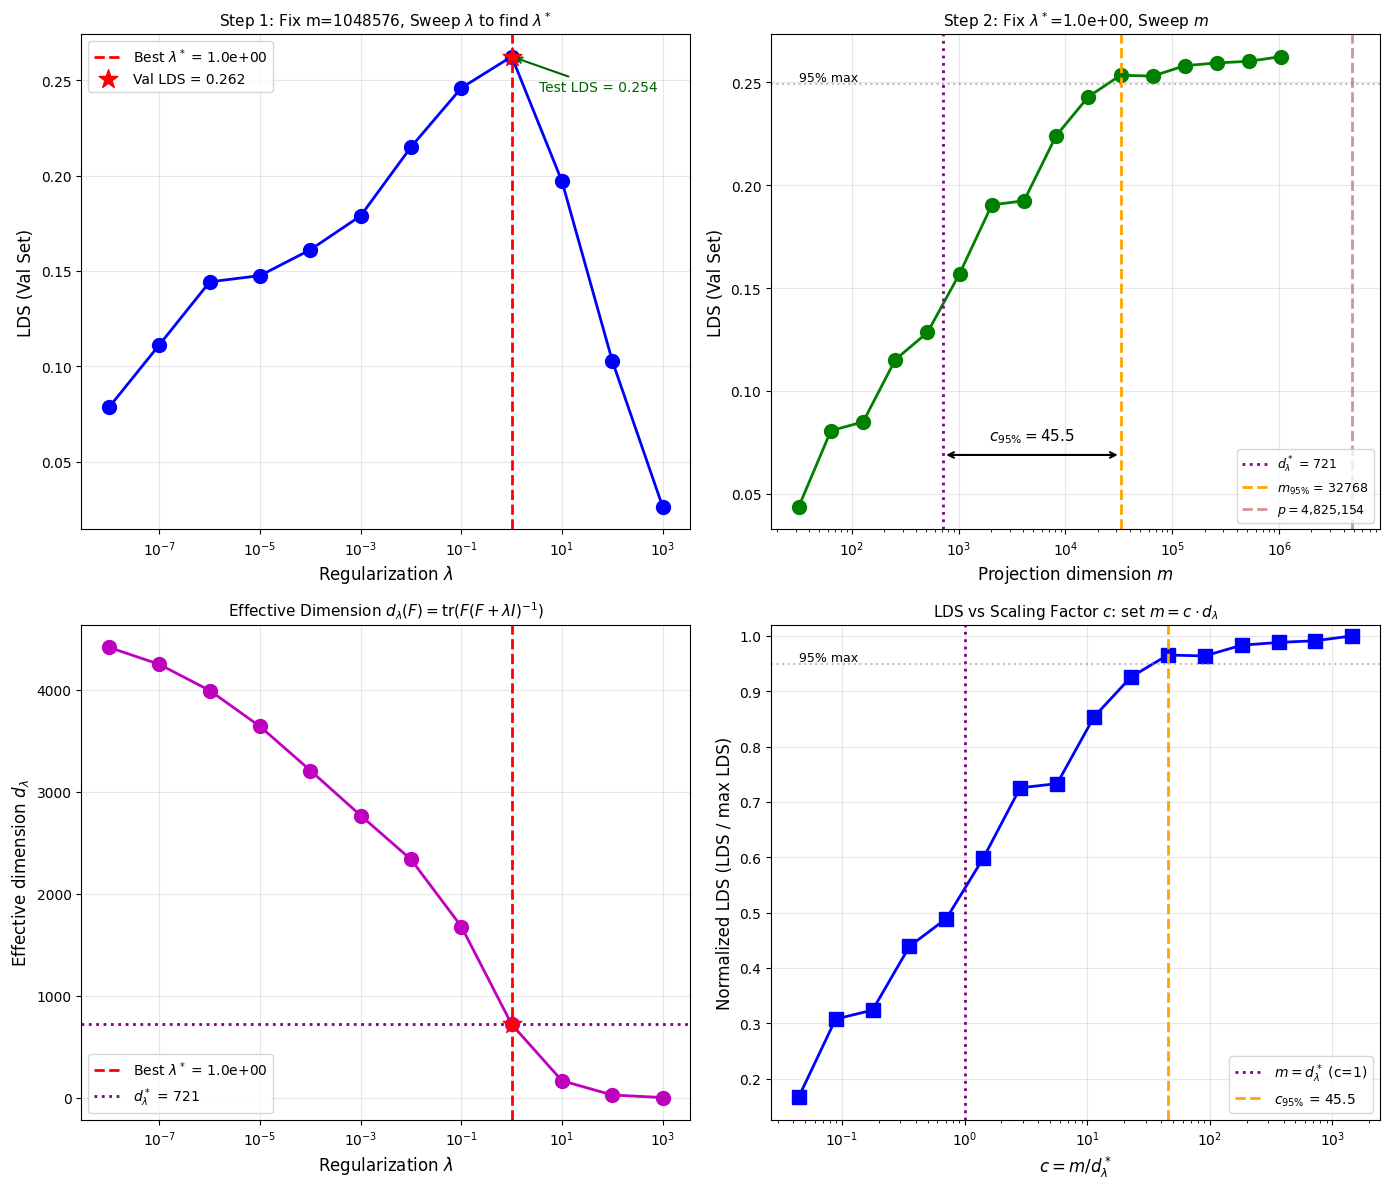


Summary: Empirical Constant c for 95% LDS
Dataset    Model      d_λ*       m_95%      c_95%     
--------------------------------------------------
mnist      lr         175        4096       23.4      
mnist      mlp        394        16384      41.6      
cifar2     resnet9    721        32768      45.5      
--------------------------------------------------
Average                                     36.8      

*** Practical Rule: set m ≈ 37 × d_λ for 95% of optimal LDS ***

All figures saved to ./figures/


In [6]:
# =============================================================================
# Generate and save all figures
# =============================================================================

figures_dir = "./figures"
os.makedirs(figures_dir, exist_ok=True)
os.makedirs(f"{figures_dir}/spectrum_bounds", exist_ok=True)
os.makedirs(f"{figures_dir}/hyperparam_selection", exist_ok=True)

# =============================================================================
# Spectrum Bounds Figures (combined self + test per setting)
# =============================================================================
spectrum_configs = [
    ("mnist", "lr"),
    ("mnist", "mlp"),
    ("cifar2", "resnet9"),
]

print("=" * 60)
print("Generating Spectrum Bounds Figures (Combined Self + Test)")
print("=" * 60)

for dataset, model in spectrum_configs:
    print(f"\n>>> {dataset.upper()} + {model.upper()}")
    save_path = f"{figures_dir}/spectrum_bounds/spectrum_{dataset}_{model}.png"
    plot_spectrum_comparison(dataset, model, save_path=save_path)

# =============================================================================
# Hyperparameter Selection Figures
# =============================================================================
hyperparam_configs = [
    ("mnist", "lr", "sjlt"),
    ("mnist", "mlp", "sjlt"),
    ("cifar2", "resnet9", "sjlt"),
]

print("\n" + "=" * 60)
print("Generating Hyperparameter Selection Figures")
print("=" * 60)

# Collect empirical constants across all experiments
all_constants = []

for dataset, model, proj_type in hyperparam_configs:
    path = f"./results/hyperparam_selection/{dataset}_{model}_{proj_type}.pt"
    if os.path.exists(path):
        print(f"\n>>> {dataset.upper()} + {model.upper()}")
        res = torch.load(path, map_location="cpu", weights_only=False)
        save_path = f"{figures_dir}/hyperparam_selection/hyperparam_{dataset}_{model}.png"
        constants = plot_comparison_results(res, save_path=save_path)
        if constants and constants.get("c_95"):
            all_constants.append({
                "dataset": dataset,
                "model": model,
                **constants
            })
    else:
        print(f"Skipping {path} (not found)")

# Summary of empirical constants
print("\n" + "=" * 60)
print("Summary: Empirical Constant c for 95% LDS")
print("=" * 60)
print(f"{'Dataset':<10} {'Model':<10} {'d_λ*':<10} {'m_95%':<10} {'c_95%':<10}")
print("-" * 50)
for c in all_constants:
    print(f"{c['dataset']:<10} {c['model']:<10} {c['d_lambda_star']:<10.0f} {c['m_95']:<10} {c['c_95']:<10.1f}")

if all_constants:
    avg_c = np.mean([c['c_95'] for c in all_constants])
    print("-" * 50)
    print(f"{'Average':<10} {'':<10} {'':<10} {'':<10} {avg_c:<10.1f}")
    print(f"\n*** Practical Rule: set m ≈ {avg_c:.0f} × d_λ for 95% of optimal LDS ***")

print("\n" + "=" * 60)
print(f"All figures saved to {figures_dir}/")
print("=" * 60)

# Faithfulness-Utility Alignment Analysis

In [7]:
# Load faithfulness-utility results (empirical version)
fu_dataset = "cifar2"
fu_model = "resnet9"
fu_proj_type = "sjlt"

# New format: no epsilon in filename
fu_results_path = f"./results/faithfulness_utility/{fu_dataset}_{fu_model}_{fu_proj_type}.pt"

if not os.path.exists(fu_results_path):
    print(f"Error: File not found at {fu_results_path}")
    print("Run the experiment first:")
    print(f"  python faithfulness_utility.py --dataset {fu_dataset} --model {fu_model}")
    fu_results = None
else:
    fu_results = torch.load(fu_results_path, map_location="cpu", weights_only=False)
    print(f"Loaded faithfulness-utility results (empirical)")
    print(f"  Dataset: {fu_results['metadata']['dataset']}")
    print(f"  Model: {fu_results['metadata']['model']}")
    print(f"  n_train: {fu_results['metadata']['n_train']}")
    print(f"  n_params: {fu_results['metadata']['n_params']:,}")
    print(f"  Faithfulness threshold: {fu_results.get('faithfulness_threshold', 'N/A')}")

Loaded faithfulness-utility results (empirical)
  Dataset: cifar2
  Model: resnet9
  n_train: 5000
  n_params: 4,825,154
  Faithfulness threshold: 0.1


In [8]:
def plot_lds_vs_lambda_curves(results, m_subset=None, figsize=(12, 8), save_path=None):
    """
    Plot LDS vs λ curves for each projection dimension m.
    Shows empirical faithfulness (mean ratio) instead of theoretical boundary.
    """
    m_values = results['m_values']
    lambda_values = np.array(results['lambda_values'])
    per_m = results['per_m_results']
    faithfulness_grid = results.get('faithfulness_grid', {})

    if m_subset is None:
        m_subset = m_values

    fig, axes = plt.subplots(1, 2, figsize=(figsize[0]*1.5, figsize[1]))

    # Color map for different m values
    colors = plt.cm.viridis(np.linspace(0, 1, len(m_subset)))

    # Left plot: LDS vs λ
    ax1 = axes[0]
    for i, m in enumerate(m_subset):
        if m not in per_m:
            continue

        data = per_m[m]
        lds_values = data['all_lds']
        lambda_star = data['lambda_star']
        lds_star = data['lds_star']

        ax1.plot(lambda_values, lds_values, color=colors[i],
                label=f'm={m}', linewidth=2, alpha=0.8)

        # Mark λ*(m) - the utility-optimal point
        ax1.scatter([lambda_star], [lds_star], color=colors[i],
                   marker='*', s=150, zorder=5, edgecolors='black', linewidths=0.5)

    ax1.set_xscale('log')
    ax1.set_xlabel('λ (regularization)')
    ax1.set_ylabel('LDS (Linear Datamodeling Score)')
    ax1.set_title('LDS vs λ for Different Projection Dimensions m\n(★ = λ*(m))')
    ax1.legend(loc='best', ncol=2, fontsize=9)
    ax1.grid(True, alpha=0.3)

    # Right plot: Faithfulness (mean ratio) vs λ
    ax2 = axes[1]
    threshold = results.get('faithfulness_threshold', 0.1)

    for i, m in enumerate(m_subset):
        if m not in per_m:
            continue

        data = per_m[m]
        all_faith = data.get('all_faithfulness', [])

        if all_faith:
            ratios = [f.get('mean_ratio', float('nan')) for f in all_faith]
            ax2.plot(lambda_values, ratios, color=colors[i],
                    label=f'm={m}', linewidth=2, alpha=0.8)

            # Mark λ*(m)
            lambda_star = data['lambda_star']
            faith_at_star = data.get('faithfulness_at_star', {})
            ratio_at_star = faith_at_star.get('mean_ratio', float('nan'))
            ax2.scatter([lambda_star], [ratio_at_star], color=colors[i],
                       marker='*', s=150, zorder=5, edgecolors='black', linewidths=0.5)

    # Add faithful region band
    ax2.axhline(y=1-threshold, color='green', linestyle='--', alpha=0.5)
    ax2.axhline(y=1+threshold, color='green', linestyle='--', alpha=0.5)
    ax2.axhspan(1-threshold, 1+threshold, alpha=0.1, color='green', label=f'Faithful region (±{threshold*100:.0f}%)')
    ax2.axhline(y=1.0, color='black', linestyle='-', alpha=0.3)

    ax2.set_xscale('log')
    ax2.set_xlabel('λ (regularization)')
    ax2.set_ylabel('Mean Ratio (sketched / exact)')
    ax2.set_title('Empirical Faithfulness vs λ\n(★ = λ*(m))')
    ax2.legend(loc='best', ncol=2, fontsize=9)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved figure to {save_path}")

    plt.show()
    return fig, axes


def plot_fu_monotonicity(results, figsize=(10, 6), save_path=None):
    """Plot LDS*(m) vs m to check monotonicity."""
    m_values = results['m_values']
    per_m = results['per_m_results']

    lds_stars = [per_m[m]['lds_star'] for m in m_values]

    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(m_values, lds_stars, 'o-', markersize=10, linewidth=2,
            color='steelblue', label='LDS*(m)')

    # Highlight violations of monotonicity
    for i in range(1, len(lds_stars)):
        if lds_stars[i] < lds_stars[i-1] - 0.005:
            ax.scatter([m_values[i]], [lds_stars[i]], color='red',
                       s=200, zorder=5, marker='x', linewidths=3,
                       label='Violation' if i == 1 else '')

    ax.set_xscale('log')
    ax.set_xlabel('Projection Dimension m')
    ax.set_ylabel('LDS*(m) = max_λ LDS(m, λ)')
    ax.set_title('Monotonicity Check: Does Optimal LDS Increase with m?')
    ax.grid(True, alpha=0.3)
    ax.legend()

    corr = np.corrcoef(np.log(m_values), lds_stars)[0, 1]
    ax.annotate(f'Correlation(log m, LDS*) = {corr:.3f}',
                xy=(0.05, 0.95), xycoords='axes fraction',
                fontsize=11, ha='left', va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved figure to {save_path}")

    plt.show()
    return fig, ax


def plot_fu_alignment(results, figsize=(12, 6), save_path=None):
    """
    Plot empirical faithfulness at λ*(m) for each m.
    Shows mean ratio and whether it's in the faithful region.
    """
    m_values = results['m_values']
    per_m = results['per_m_results']
    threshold = results.get('faithfulness_threshold', 0.1)

    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Left: Mean ratio at λ*(m) vs m
    ax1 = axes[0]
    ratios = []
    in_unfaithful = []

    for m in m_values:
        faith = per_m[m].get('faithfulness_at_star', {})
        ratio = faith.get('mean_ratio', float('nan'))
        ratios.append(ratio)
        in_unfaithful.append(per_m[m].get('in_unfaithful_region', False))

    colors = ['red' if unf else 'green' for unf in in_unfaithful]
    ax1.scatter(m_values, ratios, c=colors, s=100, zorder=5)
    ax1.plot(m_values, ratios, 'k-', alpha=0.3, linewidth=1)

    # Faithful region band
    ax1.axhline(y=1-threshold, color='green', linestyle='--', alpha=0.5)
    ax1.axhline(y=1+threshold, color='green', linestyle='--', alpha=0.5)
    ax1.axhspan(1-threshold, 1+threshold, alpha=0.1, color='green', label=f'Faithful (±{threshold*100:.0f}%)')
    ax1.axhline(y=1.0, color='black', linestyle='-', alpha=0.3)

    ax1.set_xscale('log')
    ax1.set_xlabel('Projection Dimension m')
    ax1.set_ylabel('Mean Ratio at λ*(m)')
    ax1.set_title('Empirical Faithfulness at Utility-Optimal λ*(m)\n(Green = faithful, Red = unfaithful)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Right: Bar chart of alignment
    ax2 = axes[1]
    bar_colors = ['red' if unf else 'green' for unf in in_unfaithful]
    ax2.bar(range(len(m_values)), [abs(r - 1) for r in ratios], color=bar_colors, alpha=0.7, edgecolor='black')
    ax2.axhline(y=threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold ({threshold*100:.0f}%)')

    ax2.set_xticks(range(len(m_values)))
    ax2.set_xticklabels([str(m) for m in m_values], rotation=45)
    ax2.set_xlabel('Projection Dimension m')
    ax2.set_ylabel('|Mean Ratio - 1|')
    ax2.set_title('Faithfulness Error at λ*(m)')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved figure to {save_path}")

    plt.show()
    return fig, axes


def plot_fu_heatmap(results, figsize=(14, 6), save_path=None):
    """Plot 2D heatmaps of LDS(m, λ) and faithfulness(m, λ)."""
    m_values = results['m_values']
    lambda_values = results['lambda_values']
    grid = results['grid']
    faithfulness_grid = results.get('faithfulness_grid', {})
    per_m = results['per_m_results']

    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Left: LDS heatmap
    ax1 = axes[0]
    lds_matrix = np.zeros((len(m_values), len(lambda_values)))
    for i, m in enumerate(m_values):
        for j, lamb in enumerate(lambda_values):
            lds_matrix[i, j] = grid.get((m, lamb), np.nan)

    im1 = ax1.imshow(lds_matrix, aspect='auto', origin='lower', cmap='viridis')

    ax1.set_xticks(np.arange(0, len(lambda_values), max(1, len(lambda_values)//8)))
    ax1.set_xticklabels([f'{lambda_values[i]:.1e}' for i in range(0, len(lambda_values), max(1, len(lambda_values)//8))],
                       rotation=45, ha='right')
    ax1.set_yticks(range(len(m_values)))
    ax1.set_yticklabels([str(m) for m in m_values])
    ax1.set_xlabel('λ')
    ax1.set_ylabel('m')
    ax1.set_title('LDS(m, λ)')

    cbar1 = plt.colorbar(im1, ax=ax1)
    cbar1.set_label('LDS')

    # Mark λ*(m)
    for i, m in enumerate(m_values):
        lambda_star = per_m[m]['lambda_star']
        j_star = np.argmin(np.abs(np.array(lambda_values) - lambda_star))
        ax1.scatter([j_star], [i], color='red', marker='*', s=80, zorder=5)

    # Right: Faithfulness heatmap
    ax2 = axes[1]
    faith_matrix = np.zeros((len(m_values), len(lambda_values)))
    for i, m in enumerate(m_values):
        for j, lamb in enumerate(lambda_values):
            faith = faithfulness_grid.get((m, lamb), {})
            faith_matrix[i, j] = faith.get('mean_ratio', np.nan)

    im2 = ax2.imshow(faith_matrix, aspect='auto', origin='lower', cmap='RdYlGn', vmin=0.8, vmax=1.2)

    ax2.set_xticks(np.arange(0, len(lambda_values), max(1, len(lambda_values)//8)))
    ax2.set_xticklabels([f'{lambda_values[i]:.1e}' for i in range(0, len(lambda_values), max(1, len(lambda_values)//8))],
                       rotation=45, ha='right')
    ax2.set_yticks(range(len(m_values)))
    ax2.set_yticklabels([str(m) for m in m_values])
    ax2.set_xlabel('λ')
    ax2.set_ylabel('m')
    ax2.set_title('Mean Ratio (sketched/exact)')

    cbar2 = plt.colorbar(im2, ax=ax2)
    cbar2.set_label('Ratio')

    # Mark λ*(m)
    for i, m in enumerate(m_values):
        lambda_star = per_m[m]['lambda_star']
        j_star = np.argmin(np.abs(np.array(lambda_values) - lambda_star))
        ax2.scatter([j_star], [i], color='blue', marker='*', s=80, zorder=5)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved figure to {save_path}")

    plt.show()
    return fig, axes


def plot_fu_effective_dimension(results, figsize=(10, 6), save_path=None):
    """Plot effective dimension d_λ vs λ."""
    lambda_values = np.array(results['lambda_values'])
    d_lambda = results['d_lambda']
    m_values = results['m_values']

    d_values = [d_lambda[lamb] for lamb in lambda_values]

    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(lambda_values, d_values, 'b-', linewidth=2, label='d_λ')

    # Mark m values as horizontal lines
    colors = plt.cm.tab10(np.linspace(0, 1, len(m_values)))
    for i, m in enumerate(m_values):
        ax.axhline(y=m, color=colors[i], linestyle='--', alpha=0.5, label=f'm={m}')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('λ (regularization)')
    ax.set_ylabel('Effective Dimension d_λ')
    ax.set_title('Effective Dimension d_λ vs λ\n(dashed = projection dimensions m)')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', ncol=2, fontsize=9)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved figure to {save_path}")

    plt.show()
    return fig, ax


def print_fu_summary_table(results):
    """Print a summary table with empirical faithfulness metrics."""
    m_values = results['m_values']
    per_m = results['per_m_results']
    threshold = results.get('faithfulness_threshold', 0.1)

    print(f"{'m':>8} | {'λ*(m)':>10} | {'LDS*(m)':>8} | {'Ratio':>8} | {'Corr':>6} | {'Status':>12}")
    print("-" * 70)

    for m in m_values:
        data = per_m[m]
        faith = data.get('faithfulness_at_star', {})
        ratio = faith.get('mean_ratio', float('nan'))
        corr = faith.get('correlation', float('nan'))
        is_faithful = not data.get('in_unfaithful_region', True)
        status = "faithful" if is_faithful else "UNFAITHFUL"

        print(f"{m:>8} | {data['lambda_star']:>10.2e} | {data['lds_star']:>8.4f} | "
              f"{ratio:>8.3f} | {corr:>6.3f} | {status:>12}")

In [9]:
# Run all faithfulness-utility plots
if fu_results is not None:
    print("=" * 60)
    print("Faithfulness-Utility Analysis Results")
    print("=" * 60)

    # Summary table
    print("\nSummary Table:")
    print_fu_summary_table(fu_results)

    # Analysis conclusions
    analysis = fu_results.get('analysis', {})
    if analysis:
        print("\n" + "=" * 60)
        print("ANALYSIS CONCLUSIONS")
        print("=" * 60)

        print("\n[Question 1: Alignment]")
        align = analysis.get('alignment', {})
        if align:
            print(f"  λ*(m) in unfaithful region: {align.get('n_in_unfaithful_region', '?')}/{align.get('n_total', '?')} "
                  f"({align.get('fraction_unfaithful', 0)*100:.1f}%)")
            print(f"  Conclusion: {align.get('conclusion', 'N/A')}")

        print("\n[Question 2: Monotonicity]")
        mono = analysis.get('monotonicity', {})
        if mono:
            print(f"  Correlation(m, LDS*): {mono.get('correlation_m_lds', 0):.3f}")
            print(f"  Monotonic violations: {mono.get('monotonic_violations', '?')}")
            print(f"  Conclusion: {mono.get('conclusion', 'N/A')}")

Faithfulness-Utility Analysis Results

Summary Table:
       m |      λ*(m) |  LDS*(m) |    Ratio |   Corr |       Status
----------------------------------------------------------------------
      32 |   2.68e-04 |   0.1125 |    0.680 |  0.982 |   UNFAITHFUL
      63 |   1.00e-04 |   0.1055 |    0.670 |  0.989 |   UNFAITHFUL
     127 |   3.73e-05 |   0.1219 |    0.669 |  0.990 |   UNFAITHFUL
     256 |   2.68e-05 |   0.1379 |    0.776 |  0.991 |   UNFAITHFUL
     511 |   2.68e-05 |   0.1538 |    0.875 |  0.993 |   UNFAITHFUL
    1023 |   1.39e-05 |   0.1828 |    0.896 |  0.994 |   UNFAITHFUL
    2047 |   5.18e-06 |   0.1799 |    0.905 |  0.994 |     faithful
    4095 |   7.20e-06 |   0.1863 |    0.959 |  0.995 |     faithful
    8191 |   2.68e-06 |   0.2003 |    0.964 |  0.995 |     faithful
   16383 |   2.68e-06 |   0.2031 |    0.982 |  0.995 |     faithful

ANALYSIS CONCLUSIONS

[Question 1: Alignment]
  λ*(m) in unfaithful region: 6/10 (60.0%)
  Conclusion: λ*(m) tends to be empir

### Plot 1: LDS vs λ Curves (per m) + Empirical Faithfulness

Left panel shows LDS curves, right panel shows faithfulness (mean ratio).
- **Star (★)**: λ*(m) = argmax LDS (utility-optimal)
- **Green band**: Faithful region (mean ratio within ±threshold)

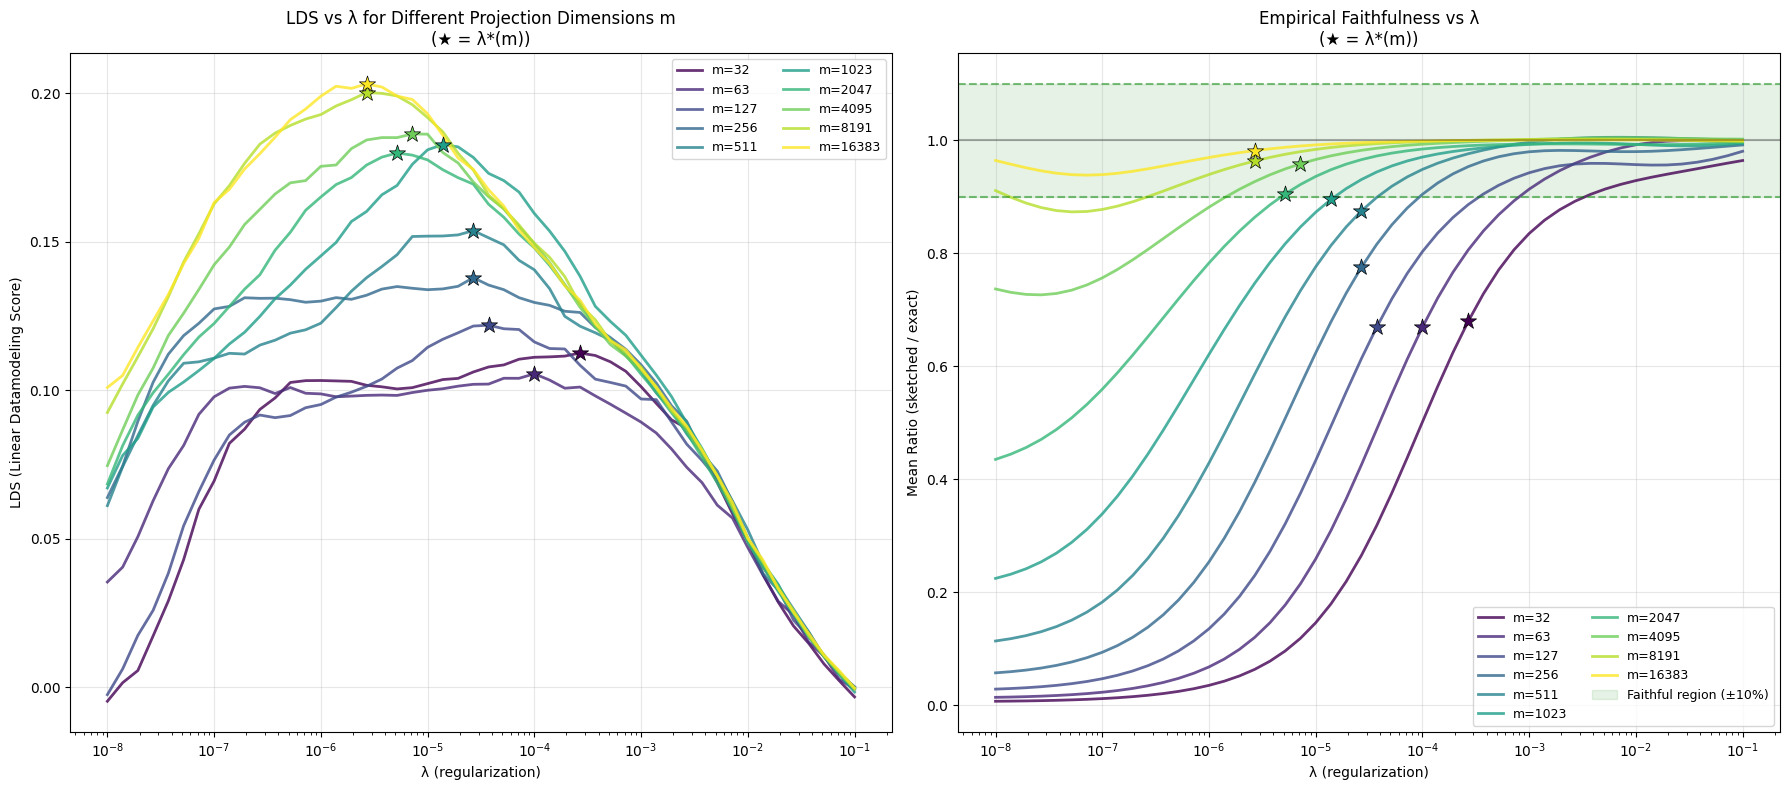

In [10]:
if fu_results is not None:
    plot_lds_vs_lambda_curves(fu_results)

### Plot 2: Monotonicity Check - LDS*(m) vs m

Check if the optimal LDS increases with projection dimension m.

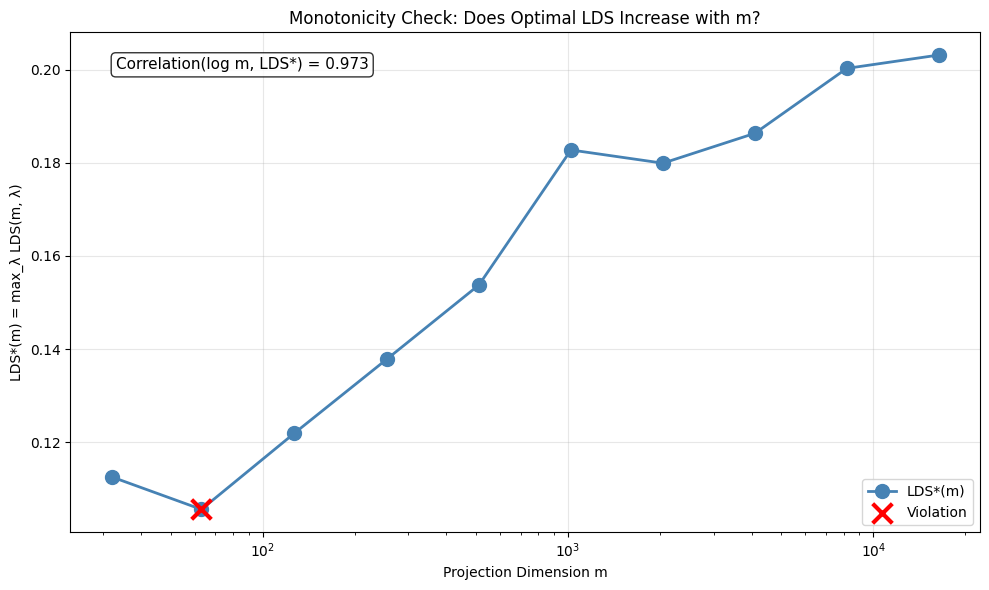

In [11]:
if fu_results is not None:
    plot_fu_monotonicity(fu_results)

### Plot 3: Alignment - Empirical Faithfulness at λ*(m)

Shows whether the utility-optimal λ*(m) produces faithful approximations.
- **Left**: Mean ratio at λ*(m) vs m (green = faithful, red = unfaithful)
- **Right**: Faithfulness error |ratio - 1| at λ*(m)

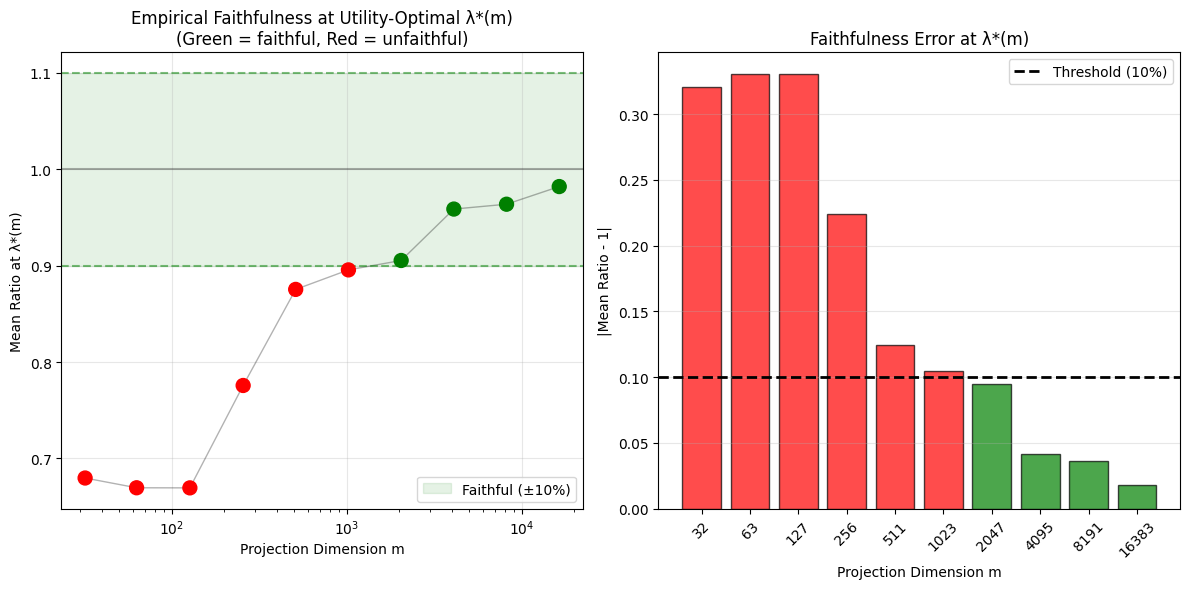

In [12]:
if fu_results is not None:
    plot_fu_alignment(fu_results)

### Plot 4: 2D Heatmaps - LDS and Faithfulness

- **Left**: LDS(m, λ) heatmap with λ*(m) marked (red stars)
- **Right**: Mean ratio (sketched/exact) heatmap with λ*(m) marked (blue stars)

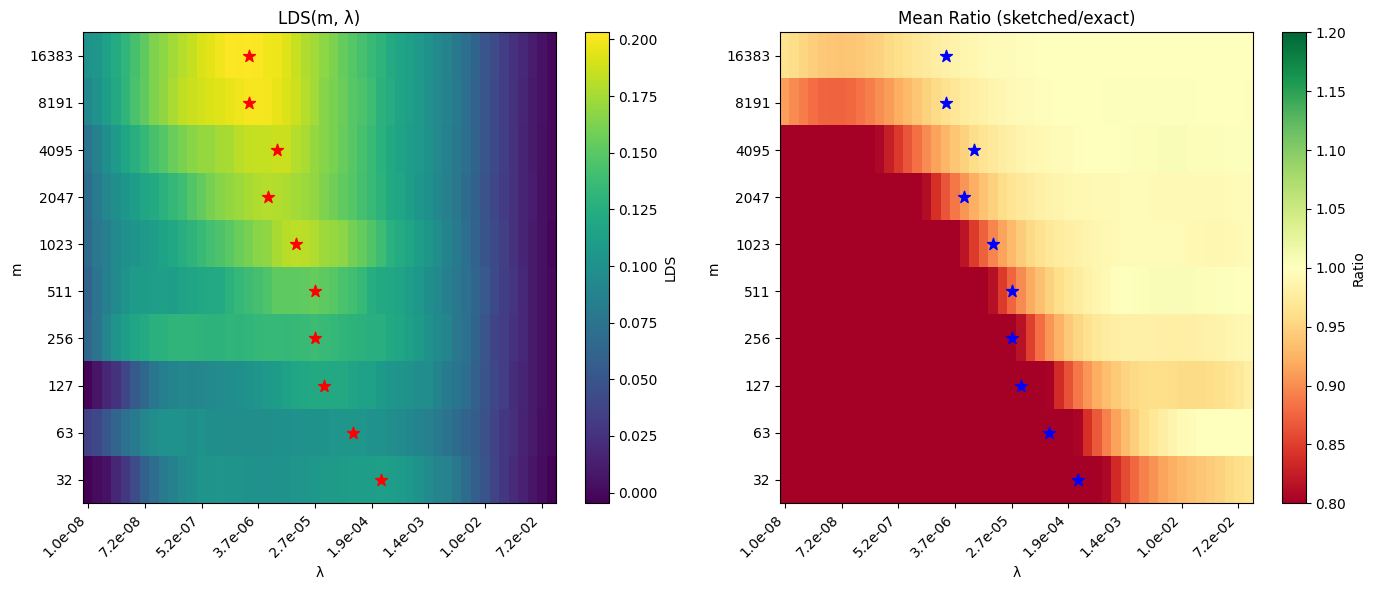

In [13]:
if fu_results is not None:
    plot_fu_heatmap(fu_results)

### Plot 6: Effective Dimension d_λ vs λ

Shows how effective dimension varies with regularization, with horizontal lines marking ε²m thresholds.

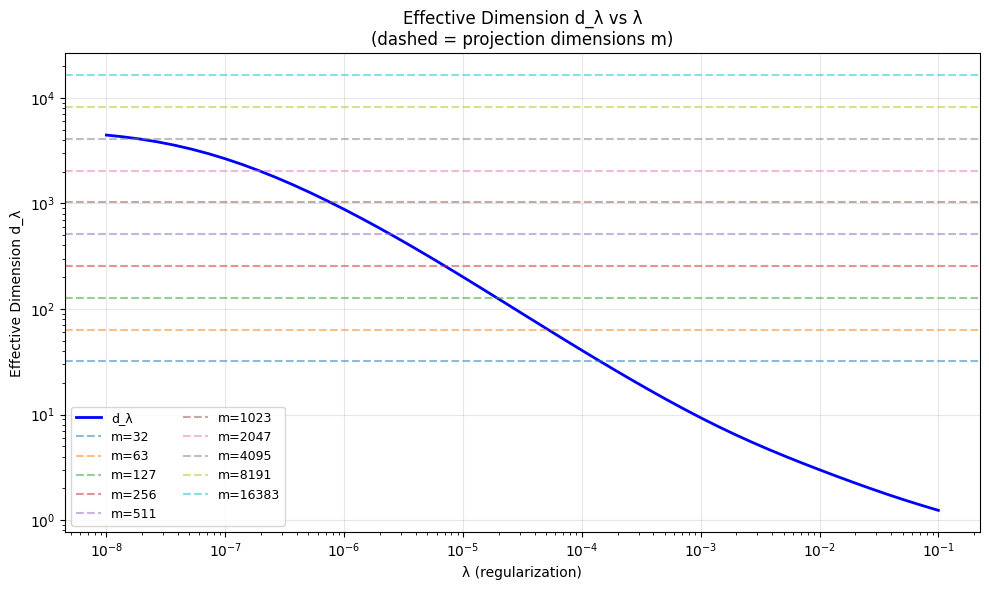

In [14]:
if fu_results is not None:
    plot_fu_effective_dimension(fu_results)

### Save All Faithfulness-Utility Figures

Saving figures to ./figures/faithfulness_utility/...
Saved figure to ./figures/faithfulness_utility/cifar2_resnet9_lds_faithfulness.png


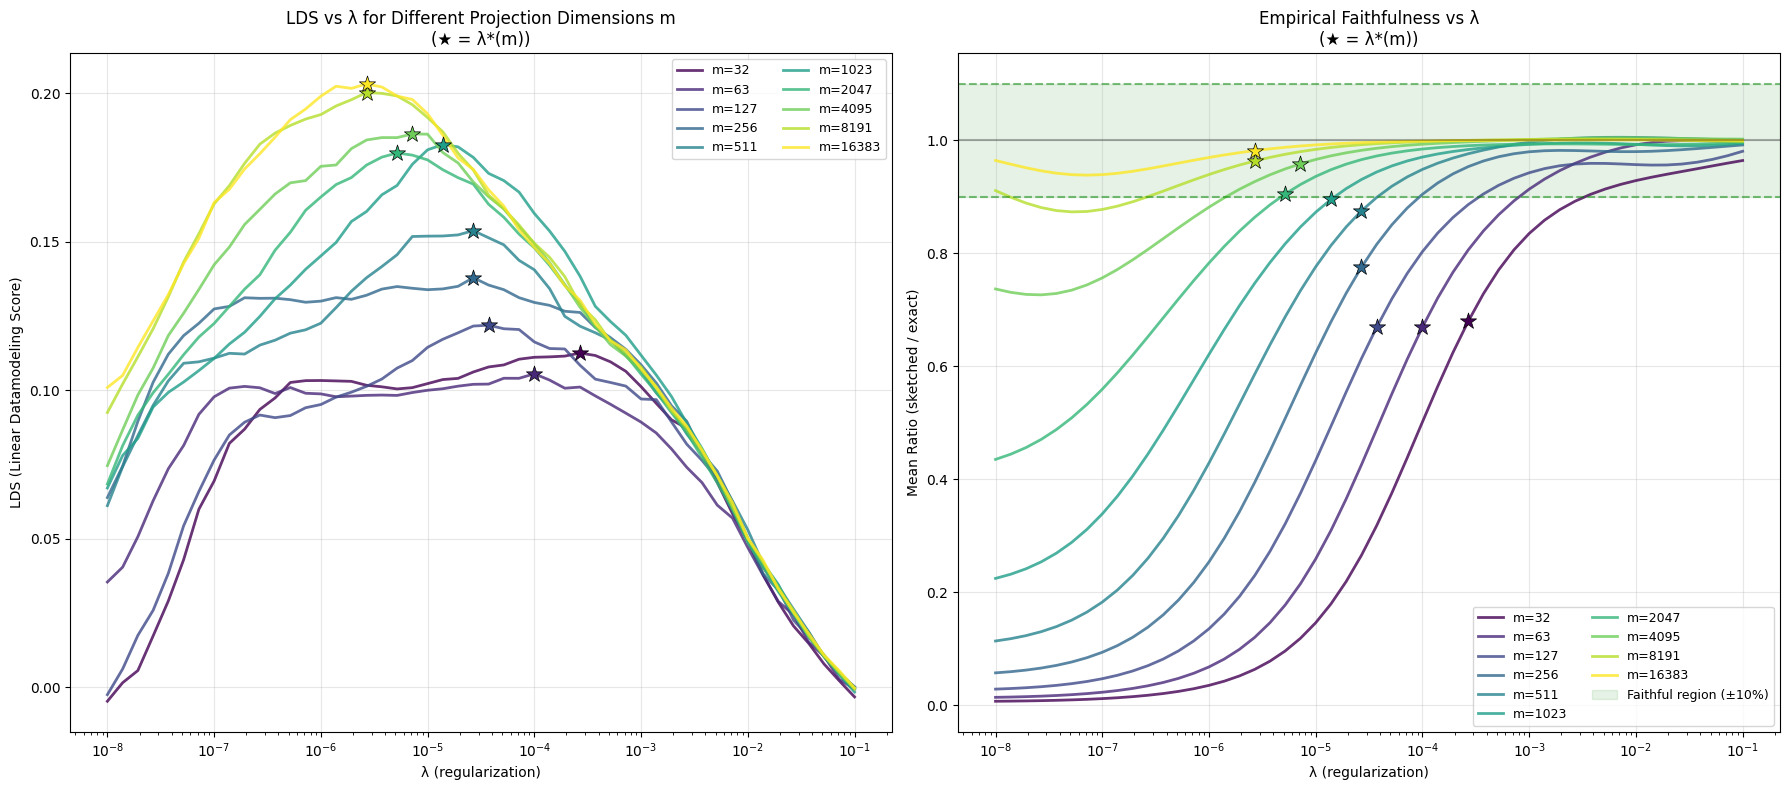

Saved figure to ./figures/faithfulness_utility/cifar2_resnet9_monotonicity.png


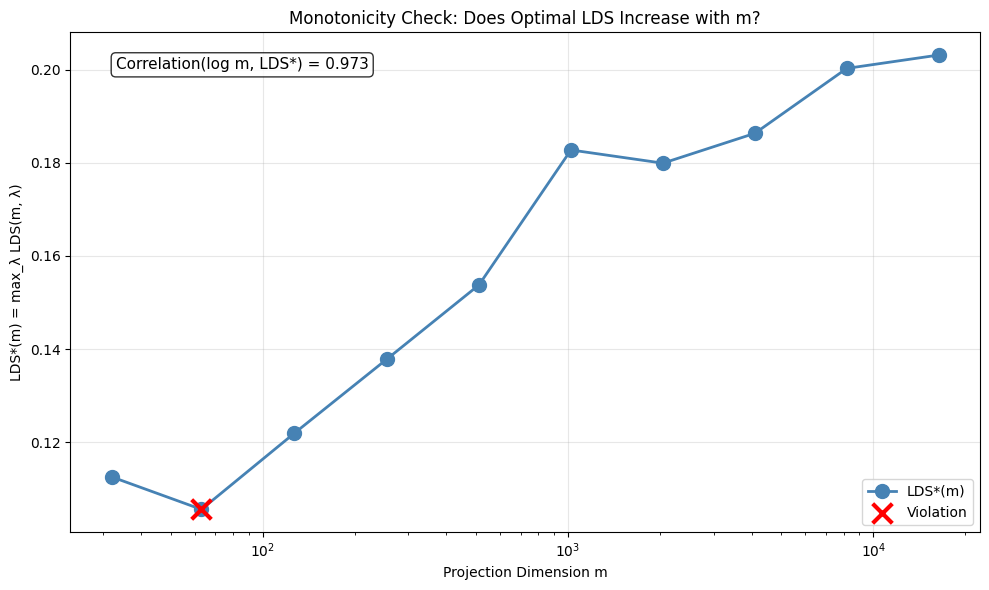

Saved figure to ./figures/faithfulness_utility/cifar2_resnet9_alignment.png


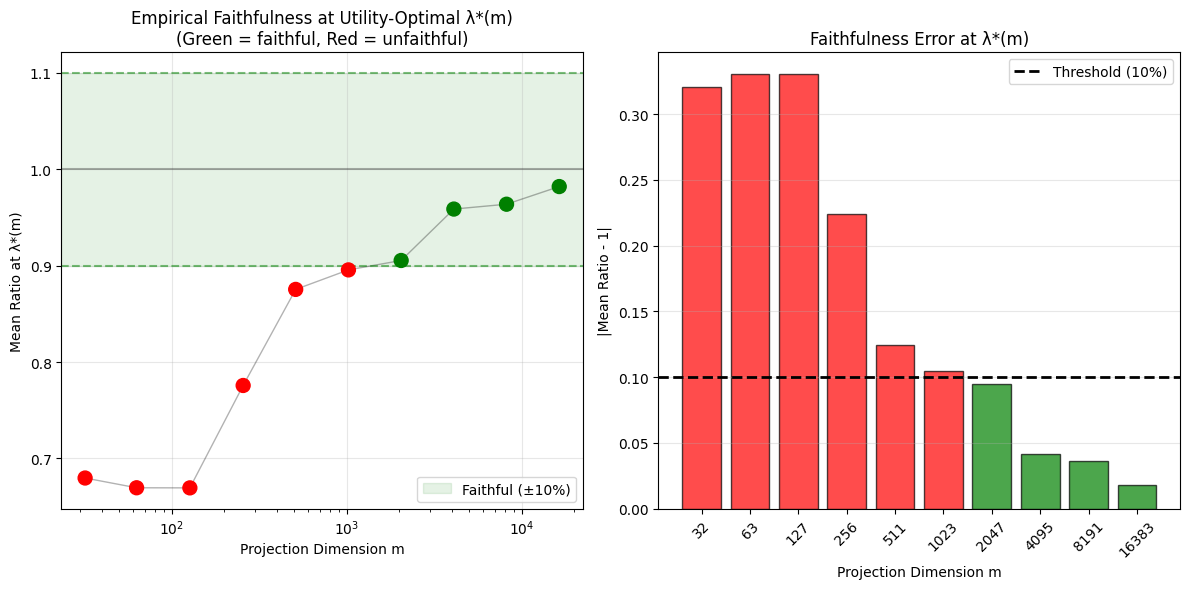

Saved figure to ./figures/faithfulness_utility/cifar2_resnet9_heatmap.png


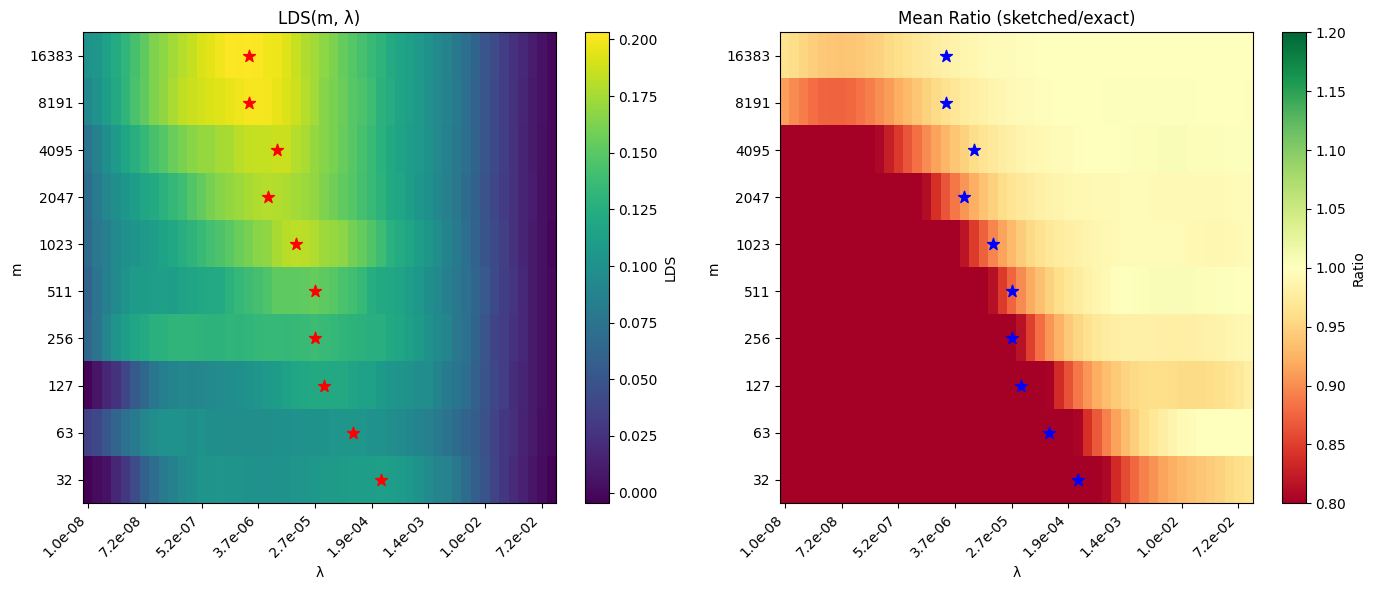

Saved figure to ./figures/faithfulness_utility/cifar2_resnet9_effective_dim.png


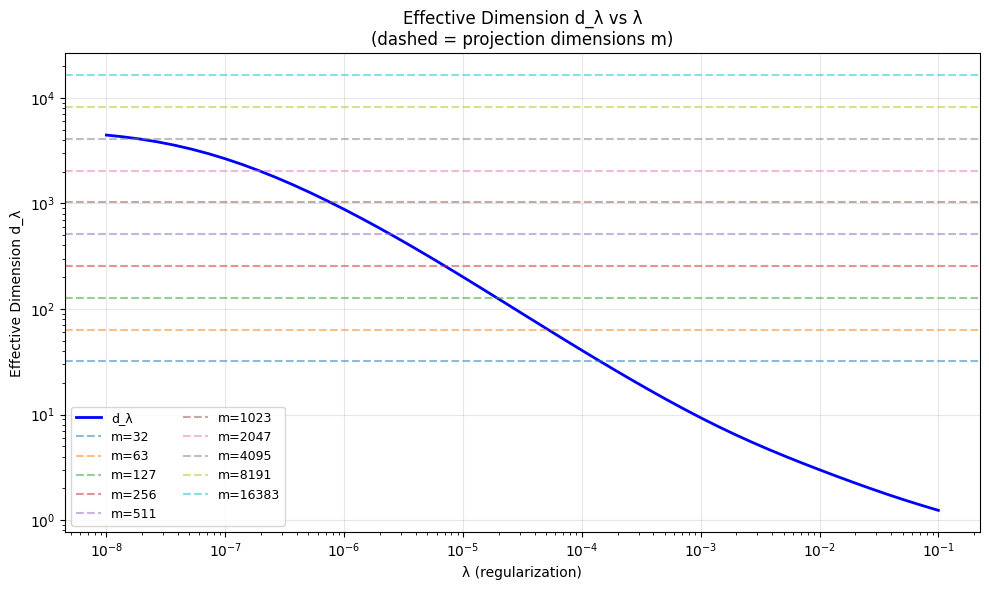


All figures saved to ./figures/faithfulness_utility/


In [15]:
# Save all faithfulness-utility figures
if fu_results is not None:
    fu_figures_dir = "./figures/faithfulness_utility"
    os.makedirs(fu_figures_dir, exist_ok=True)

    prefix = f"{fu_dataset}_{fu_model}"

    print(f"Saving figures to {fu_figures_dir}/...")

    plot_lds_vs_lambda_curves(fu_results, save_path=f"{fu_figures_dir}/{prefix}_lds_faithfulness.png")
    plot_fu_monotonicity(fu_results, save_path=f"{fu_figures_dir}/{prefix}_monotonicity.png")
    plot_fu_alignment(fu_results, save_path=f"{fu_figures_dir}/{prefix}_alignment.png")
    plot_fu_heatmap(fu_results, save_path=f"{fu_figures_dir}/{prefix}_heatmap.png")
    plot_fu_effective_dimension(fu_results, save_path=f"{fu_figures_dir}/{prefix}_effective_dim.png")

    print(f"\nAll figures saved to {fu_figures_dir}/")
    plt.close('all')